# Análisis cuentas por cobrar 


## Introducción 

En este proyecto se toman dato de cuentas por cobrar de una empresa de IT. El objetivo es identificar que clientes son aquellos que tienen pagos muy atrasados y por ende sería más recomendable para la empresa delegar a un despacho de cobranza, así mismo se buscará agrupar a los clientes mediante aquellos que tengan pocos días de atraso en los pagos con el fin de identifiacr que caracteristicas tienen los clientes más morosos o aquellos que pagan a tiempo. 

Los datos con los que cuenta nuestro dataset son los siguientes: 

- countryCode: Códifgo del país del cliente 	
- customerID: Número de idenitficaión del cliente
- PaperlessDate: 	
- invoiceNumber: Número de factura 	
- InvoiceDate: Fecha de facturación 	
- DueDate: Fecha prevista de pago (aproxiamdamente 30 dias)
- InvoiceAmount: Monto de la factura	
- Disputed: Indica si la factura está en disputa o no, en caso positivo signiifca que el cliente ha decidido que no es responsable del pago de la factura. 	
- SettledDate: Fecha límite de pago	
- PaperlessBill: indica si la factura se entregó en papel o de manera electrónica. 	
- DaysToSettle: Días trnascurridos para fecha límite de pago
- DaysLate. Indica el número de días de atraso. 

## Importación de librerias y lectura de datos
A continuación se importan las librerias de python necesarias para el análsisis

In [1]:
#Importar librerias para EDA
import pandas as pd
import numpy as np
#Importar librerias de visualización
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#Importar librerias de análisis estadístico
import scipy.stats as st
from statsmodels.stats.weightstats import ztest
#Importar librerias para Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Procedemos a leer los datos los cuales se encuentran en un archivo CSV, que se encuentra adjunto en el repositorio del proyecto.

In [2]:
#Leer datasets , con un try except en caso de no lograr leerse desde plataforma 
try:
    df = pd.read_csv('C:/Users/USUARIO/Desktop/WA_Fn-UseC_-Accounts-Receivable.csv')
except:
    df = pd.read_csv('/datasets/WA_Fn-UseC_-Accounts-Receivable.csv')
   

## Exploración y limpieza de datos

In [3]:
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 1.2 MB


In [5]:
#Cambiamos tipo de datos y columnas 
df['PaperlessDate'] = pd.to_datetime(df['PaperlessDate']).dt.tz_localize(None)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.tz_localize(None)
df['DueDate'] = pd.to_datetime(df['DueDate']).dt.tz_localize(None)
df['SettledDate'] = pd.to_datetime(df['SettledDate']).dt.tz_localize(None)
df['Disputed'] = df['Disputed'].astype('category')
df['PaperlessBill'] = df['PaperlessBill'].astype('category')


In [6]:
#Cambiar nombre de columnas
df = df.rename(columns={
'countryCode' : 'country',
'customerID' : 'customer_id',  
'PaperlessDate' : 'paperless_date', 
'invoiceNumber': 'invoice_number', 
'InvoiceDate' : 'invoice_date',
'DueDate' : 'due_date',      
'InvoiceAmount' : 'invoice_amount', 
'Disputed' : 'disputed',   
'SettledDate' : 'settled_date',   
'PaperlessBill': 'paperless_bill', 
'DaysToSettle' : 'days_to_settle',  
'DaysLate' : 'days_late'
    })

In [7]:
#Revismos cambios 
df.head()

,country,customer_id,paperless_date,invoice_number,invoice_date,due_date,invoice_amount,disputed,settled_date,paperless_bill,days_to_settle,days_late
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,No,2013-01-15,Paper,13,0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,Yes,2013-03-03,Electronic,36,6
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,No,2013-07-08,Electronic,5,0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,No,2013-03-17,Electronic,35,5
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,Yes,2012-11-28,Paper,34,4


In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   country         2466 non-null   int64         
 1   customer_id     2466 non-null   object        
 2   paperless_date  2466 non-null   datetime64[ns]
 3   invoice_number  2466 non-null   int64         
 4   invoice_date    2466 non-null   datetime64[ns]
 5   due_date        2466 non-null   datetime64[ns]
 6   invoice_amount  2466 non-null   float64       
 7   disputed        2466 non-null   category      
 8   settled_date    2466 non-null   datetime64[ns]
 9   paperless_bill  2466 non-null   category      
 10  days_to_settle  2466 non-null   int64         
 11  days_late       2466 non-null   int64         
dtypes: category(2), datetime64[ns](4), float64(1), int64(4), object(1)
memory usage: 340.1 KB


### Análsis valores nulos y duplicados 

In [9]:
df.isna().sum()

country           0
customer_id       0
paperless_date    0
invoice_number    0
invoice_date      0
due_date          0
invoice_amount    0
disputed          0
settled_date      0
paperless_bill    0
days_to_settle    0
days_late         0
dtype: int64

In [10]:
df.duplicated().value_counts()

False    2466
Name: count, dtype: int64

In [11]:
#Revisamos cuales son los valores duplicados
df_duplicated = df[df.duplicated(keep=False)]

In [12]:
#Revisamos los valores duplciados en una lista
df_duplicated = df_duplicated.groupby(df_duplicated.columns.tolist()).apply(lambda x: x.index.tolist()).values.tolist()
df_duplicated

[]

In [13]:
unique = df['invoice_number'].unique()

Observamos que no hay valores ausente o duplicados por lo que se procede al análisis exploratorio

## Análisis exploratorio de datos

df.describe().T

In [14]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
country,2466.0,620.446067,391.0,406.0,770.0,818.0,897.0,215.93361
paperless_date,2466,2012-12-24 15:41:53.868613120,2012-01-09 00:00:00,2012-07-31 00:00:00,2012-12-31 00:00:00,2013-06-03 00:00:00,2013-11-27 00:00:00,NaN
invoice_number,2466.0,4978430514.972425,611365.0,2528853991.0,4964228313.5,7494512439.0,9990243864.0,2884271865.47071
invoice_date,2466,2012-12-19 14:56:21.021897728,2012-01-03 00:00:00,2012-07-02 00:00:00,2012-12-22 00:00:00,2013-06-05 00:00:00,2013-12-02 00:00:00,NaN
due_date,2466,2013-01-18 14:56:21.021897728,2012-02-02 00:00:00,2012-08-01 00:00:00,2013-01-21 00:00:00,2013-07-05 00:00:00,2014-01-01 00:00:00,NaN
invoice_amount,2466.0,59.895856,5.26,46.4,60.56,73.765,128.28,20.435838
settled_date,2466,2013-01-15 01:36:56.058394112,2012-01-13 00:00:00,2012-07-30 00:00:00,2013-01-15 00:00:00,2013-07-02 00:00:00,2014-01-09 00:00:00,NaN
days_to_settle,2466.0,26.44485,0.0,18.0,26.0,35.0,75.0,12.33493
days_late,2466.0,3.442417,0.0,0.0,0.0,5.0,45.0,6.290607


Conteos por pais 

In [15]:
# Conteo de facturas por país (region)
facturas_por_pais = df.groupby('country')['invoice_number'].nunique().reset_index()
facturas_por_pais.columns = ['Region', 'Numero de Facturas']

# Ordenar por mayor número de facturas
facturas_por_pais = facturas_por_pais.sort_values(by='Numero de Facturas', ascending=False)

# Mostrar tabla de número de facturas por país ordenado
print("Número de facturas por país (ordenado por mayor número de facturas):")
facturas_por_pais

Número de facturas por país (ordenado por mayor número de facturas):


,Region,Numero de Facturas
0,391,616
1,406,561
2,770,506
4,897,396
3,818,387


In [16]:
# Conteo de clientes por país (region)
clientes_por_pais = df.groupby('country')['customer_id'].nunique().reset_index() 
clientes_por_pais.columns = ['Region', 'Numero de clientes']

# Ordenar por mayor número 
clientes_por_pais = clientes_por_pais.sort_values(by='Numero de clientes', ascending=False)

# Mostrar tabla de número de clientes por país ordenado
print("Número de clientes por país (ordenado por mayor número de facturas):")
clientes_por_pais

Número de clientes por país (ordenado por mayor número de facturas):


,Region,Numero de clientes
0,391,25
1,406,23
2,770,20
3,818,16
4,897,16


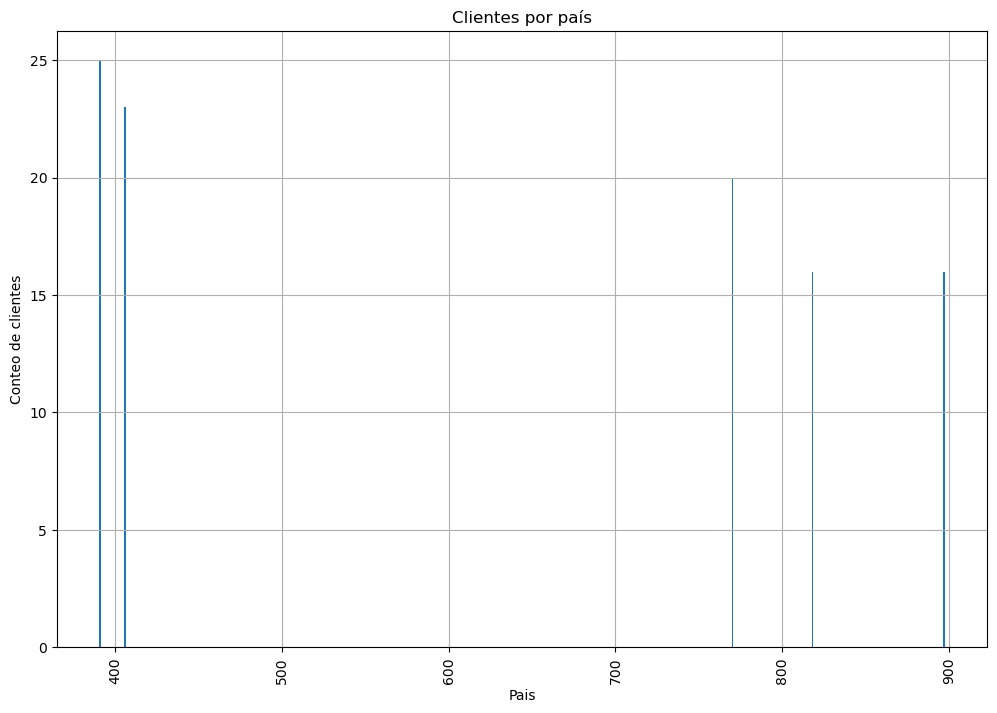

In [17]:
plt.figure(figsize=(12, 8))
plt.bar(clientes_por_pais['Region'], clientes_por_pais['Numero de clientes'] )
plt.title('Clientes por país')
plt.xlabel('Pais')
plt.ylabel('Conteo de clientes')
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()

In [18]:
data_filtered = df.query('disputed == "Yes"')
disputed_por_pais = data_filtered.groupby('country')['disputed'].count().reset_index() 
disputed_por_pais.columns = ['Region', 'Facturas en disputa']

# Ordenar por mayor número 
disputed_por_pais = disputed_por_pais.sort_values(by='Facturas en disputa', ascending=False)

# Mostrar tabla de número de clientes por país ordenado
print("Facturas en disputa por país (ordenado por mayor número de facturas):")
disputed_por_pais

Facturas en disputa por país (ordenado por mayor número de facturas):


,Region,Facturas en disputa
1,406,212
3,818,149
2,770,80
0,391,61
4,897,59


Observamos que las regiones con mayor cantidad de disputa de pago no son necesariamente las regiones con más facturas totales, por lo que podríamos decir que podría haber un patrón sobr clientes problemáticos. 
A continuación vamos a revisar las fechas de las facturas y los días de atraso, para saber si tenemos algún patrón en cuanto a términos de fecha. 


Revisamos las facturas por mes y año 

In [19]:
# Crear una nueva columna 'Month' y 'Year' para el mes de cada factura
df['Month'] = df['invoice_date'].dt.month
df['Year'] = df['invoice_date'].dt.year


In [20]:
# Conteo de facturas por mes
facturas_por_mes = df.groupby('Month')['invoice_number'].nunique().reset_index()
facturas_por_mes.columns = ['Mes', 'Número de Facturas']

# Mostrar tabla de número de facturas por mes
print("Número de facturas generadas por mes:")
facturas_por_mes

Número de facturas generadas por mes:


,Mes,Número de Facturas
0,1,201
1,2,197
2,3,223
3,4,209
4,5,237
5,6,197
6,7,216
7,8,205
8,9,240
9,10,202


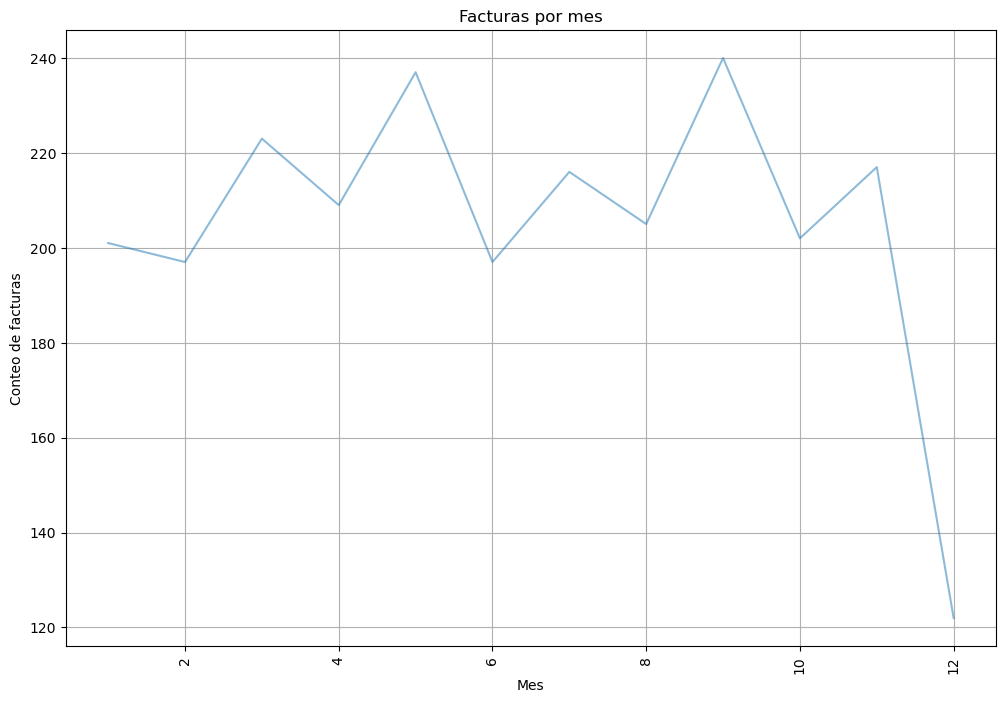

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(facturas_por_mes['Mes'], facturas_por_mes['Número de Facturas'], alpha=0.5, )
plt.title('Facturas por mes')
plt.xlabel('Mes')
plt.ylabel('Conteo de facturas')
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()

In [22]:
# Conteo de facturas por mes
facturas_por_año = df.groupby('Year')['invoice_number'].nunique().reset_index()
facturas_por_año.columns = ['Año', 'Número de Facturas']

# Mostrar tabla de número de facturas por mes
print("Número de facturas generadas por año:")
facturas_por_año

Número de facturas generadas por año:


,Año,Número de Facturas
0,2012,1277
1,2013,1189


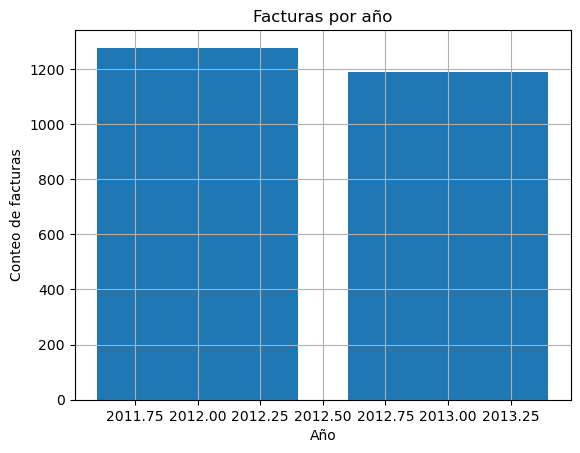

In [23]:
plt.bar(facturas_por_año['Año'], facturas_por_año['Número de Facturas'])
plt.title('Facturas por año')
plt.xlabel('Año')
plt.ylabel('Conteo de facturas')
plt.grid(True)
plt.show()

Revisaremos a continuación las facturas en disputa por fecha de factura 

In [24]:
#Recuperamos los datos filtrados con facturas en disputa 
# Crear una nueva columna 'Month' y 'Year' para el mes de cada factura
data_filtered['Month'] = data_filtered['invoice_date'].dt.month
data_filtered['Year'] = data_filtered['invoice_date'].dt.year


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_6424\447960506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Month'] = data_filtered['invoice_date'].dt.month
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_6424\447960506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Year'] = data_filtered['invoice_date'].dt.year


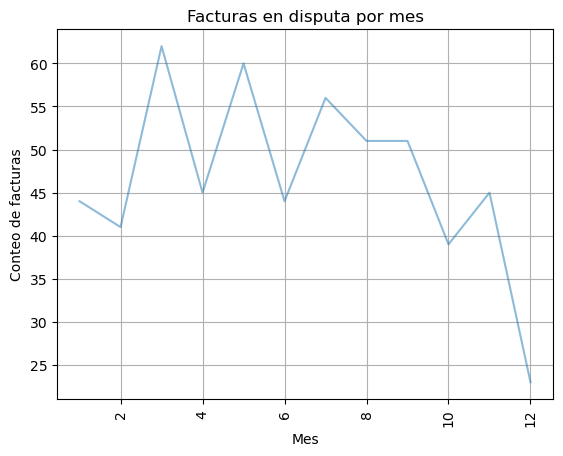

In [25]:
#Agrupamos los datos como en el caso anterior
facturas_disputa_por_mes = data_filtered.groupby('Month')['invoice_number'].nunique().reset_index()
facturas_disputa_por_mes.columns = ['Mes', 'Número de Facturas']

# Graficamos
plt.plot(facturas_disputa_por_mes['Mes'], facturas_disputa_por_mes['Número de Facturas'], alpha=0.5, )
plt.title('Facturas en disputa por mes')
plt.xlabel('Mes')
plt.ylabel('Conteo de facturas')
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()

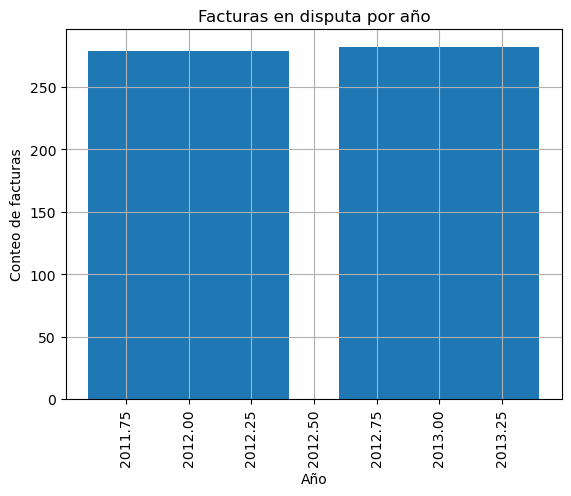

In [26]:
#Repetimos el proceso por año 
facturas_disputa_por_año = data_filtered.groupby('Year')['invoice_number'].nunique().reset_index()
facturas_disputa_por_año.columns = ['Año', 'Número de Facturas']

# Graficamos
plt.bar(facturas_disputa_por_año['Año'], facturas_disputa_por_año['Número de Facturas'])
plt.title('Facturas en disputa por año')
plt.xlabel('Año')
plt.ylabel('Conteo de facturas')
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()

Observamos que si bien en los meses se tiene un patrón más o menos similar en cuanto a número de facturas y facturas en disputa, para el caso anual pasa lo contrario ya que se pensaría que si el número de facturas totales ha bajado en 2013, se debería tener un número menor de facturas, aunque si se observa la gráfica este número no es mucho si es un tema a considerar

A continuación agruparemos por clusteres para obtener más hallazgos sobre las caracteristicas de clientes con facturas en disputa

## Agrupación por clústeres

In [27]:
#Cambiamos el tipo de datos en la columna disputed 
df.disputed = df.disputed.replace({"Yes": True, "No": False})
df['disputed']=df['disputed'].astype('bool')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   country         2466 non-null   int64         
 1   customer_id     2466 non-null   object        
 2   paperless_date  2466 non-null   datetime64[ns]
 3   invoice_number  2466 non-null   int64         
 4   invoice_date    2466 non-null   datetime64[ns]
 5   due_date        2466 non-null   datetime64[ns]
 6   invoice_amount  2466 non-null   float64       
 7   disputed        2466 non-null   bool          
 8   settled_date    2466 non-null   datetime64[ns]
 9   paperless_bill  2466 non-null   category      
 10  days_to_settle  2466 non-null   int64         
 11  days_late       2466 non-null   int64         
 12  Month           2466 non-null   int32         
 13  Year            2466 non-null   int32         
dtypes: bool(1), category(1), datetime64[ns](4), float64(1), 

In [29]:
#quitar columnas no necesarias para el análsisis 
ml_df = df.drop(['paperless_date', 'invoice_date', 'due_date','settled_date','customer_id'], axis=1)

ml_df = pd.get_dummies(ml_df)
ml_df.head()

,country,invoice_number,invoice_amount,disputed,days_to_settle,days_late,Month,Year,paperless_bill_Electronic,paperless_bill_Paper
0,391,611365,55.94,False,13,0,1,2013,False,True
1,406,7900770,61.74,True,36,6,1,2013,True,False
2,391,9231909,65.88,False,5,0,7,2013,True,False
3,406,9888306,105.92,False,35,5,2,2013,True,False
4,818,15752855,72.27,True,34,4,10,2012,False,True


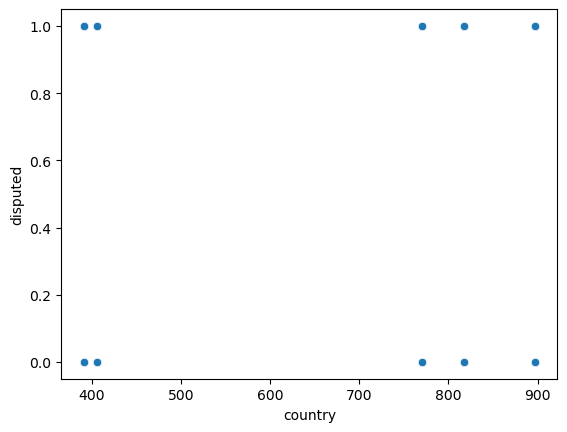

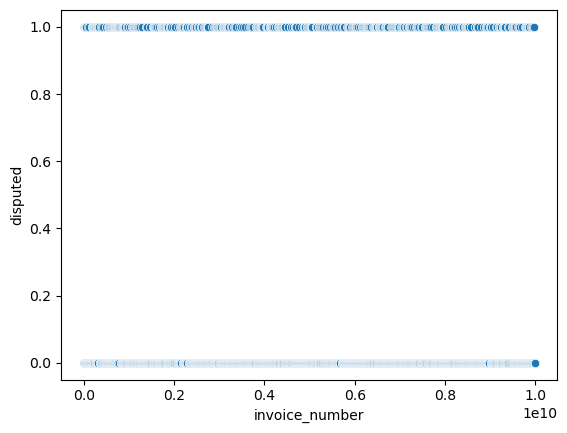

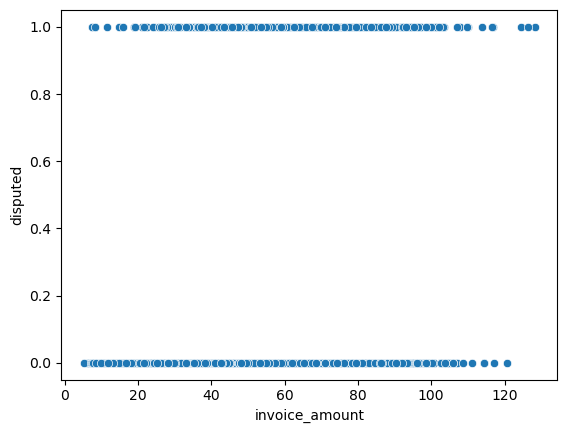

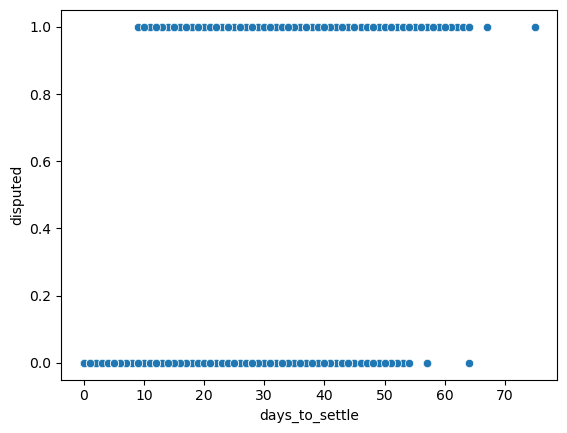

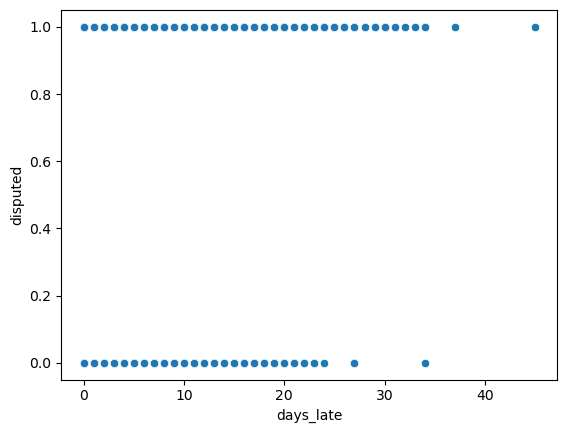

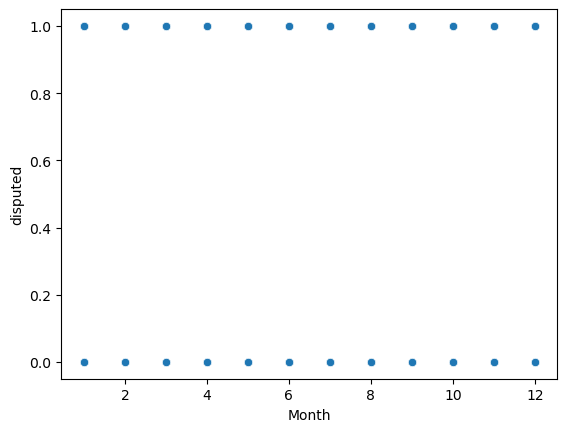

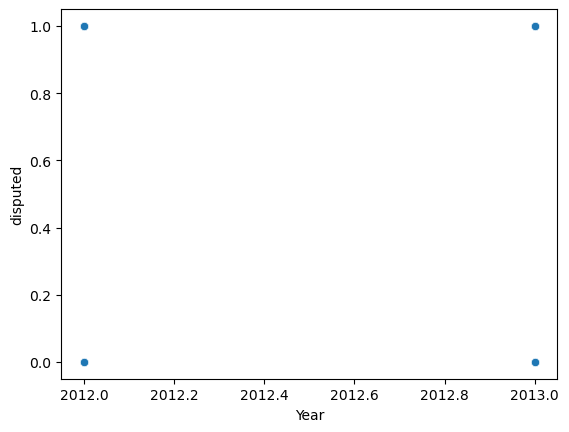

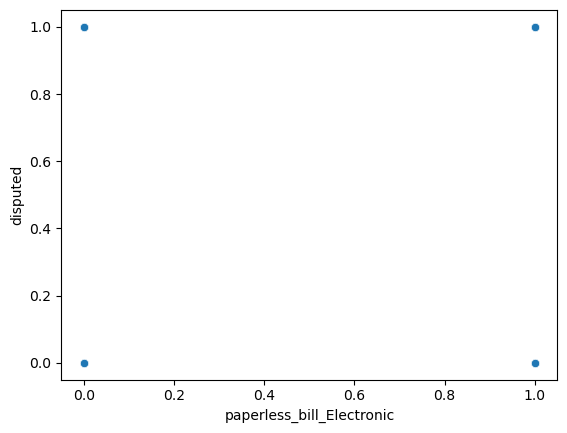

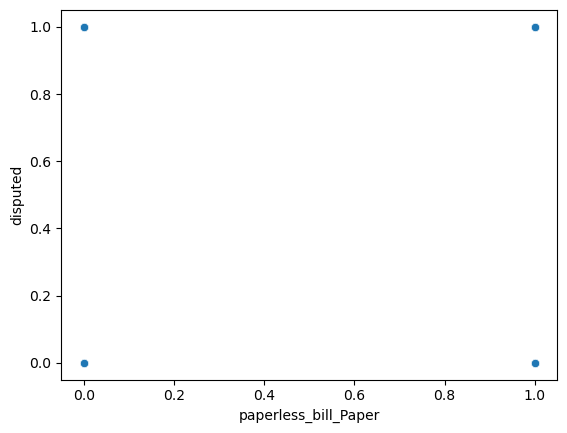

In [30]:
#Trazamos graficas de dispersión y matriz de correlación para averiguar como se relacionan las variables con nuestra variable objetivo, saber si la factura esta en disputa
for col in ml_df.drop('disputed', axis=1).columns:
    sns.scatterplot(x=ml_df[col], y=ml_df['disputed'])
    plt.show()

In [31]:
#Crear matriz de correlación 
cm = ml_df.corr() # calcula la matriz de correlación

<Figure size 2000x1500 with 0 Axes>

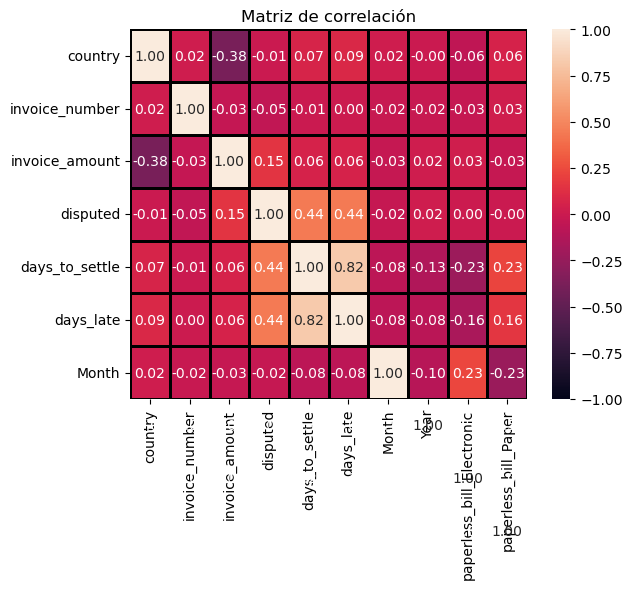

In [32]:
# traza el mapa de calor anotado para la matriz de correlación
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots()
plt.title('Matriz de correlación')
sns.heatmap(
    cm,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='black',
)
ax.set_ylim(7, 0) # corrige los campos "irregulares" del mapa de calor en la última versión de la librería
plt.show()

Observamos que las variables con más relación son days_to_settle y days_late, por lo tanto hay que ver como afectan estas variables uan vez se agrupe por clusteres, y en mucho menor medida el tipo de factura (papel o electronica), parece que no será una variable tan determinante pero podría ser interesante analizarla.

In [33]:
#Estandariza los datos.
sc = StandardScaler()
x_sc = sc.fit_transform(ml_df)

In [34]:
#Utiliza la función linkage()
linked = linkage(x_sc, method = 'ward')

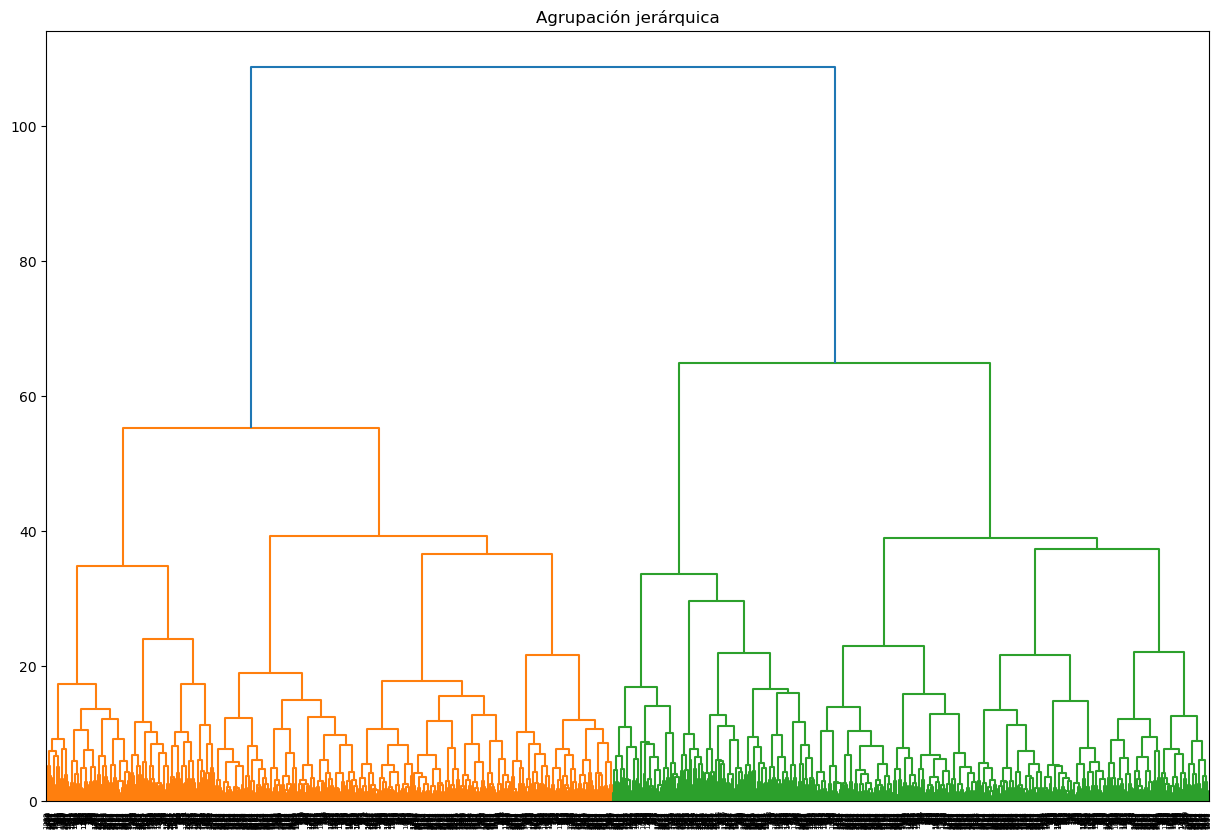

In [35]:
#trazar un dendrograma
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica')
plt.show()

Observamos que el número ideal de clusters es 2

In [36]:
#Entrena el modelo de clustering con el algortimo K-means 
km = KMeans(n_clusters=2)
# predice los clústeres para las observaciones (el algoritmo les asigna un número de 0 a 4)
labels = km.fit_predict(x_sc)
# almacena etiquetas de clúster en el campo de nuestro conjunto de datos
ml_df['cluster_km'] = labels

# obtiene las estadísticas de los valores medios de las características por clúster
ml_df.groupby(['cluster_km']).mean()

c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,country,invoice_number,invoice_amount,disputed,days_to_settle,days_late,Month,Year,paperless_bill_Electronic,paperless_bill_Paper
cluster_km,,,,,,,,,,
0,632.862342,5.052319e+09,59.379082,0.226266,29.200949,4.477057,5.590981,2012.234968,0.000791,0.999209
1,607.389351,4.900731e+09,60.439285,0.228785,23.546589,2.354409,7.140599,2012.742097,1.000000,0.000000


### Visualizacion de variables por cluster

In [37]:
#Traza distribuciones de características para los clústeres. 
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(x=df[x_name], y=df[y_name],
          hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

A continuación veremos como se relacionan todas las variables con la disputa de las facturas.

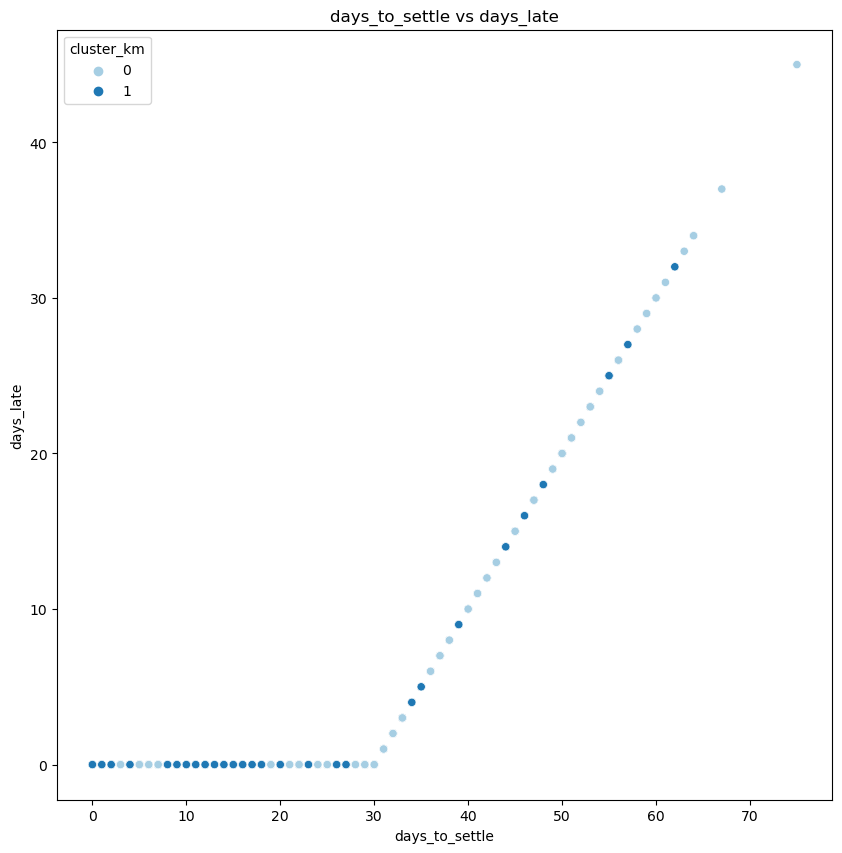

In [38]:
show_clusters_on_plot(ml_df, 'days_to_settle', 'days_late', 'cluster_km')

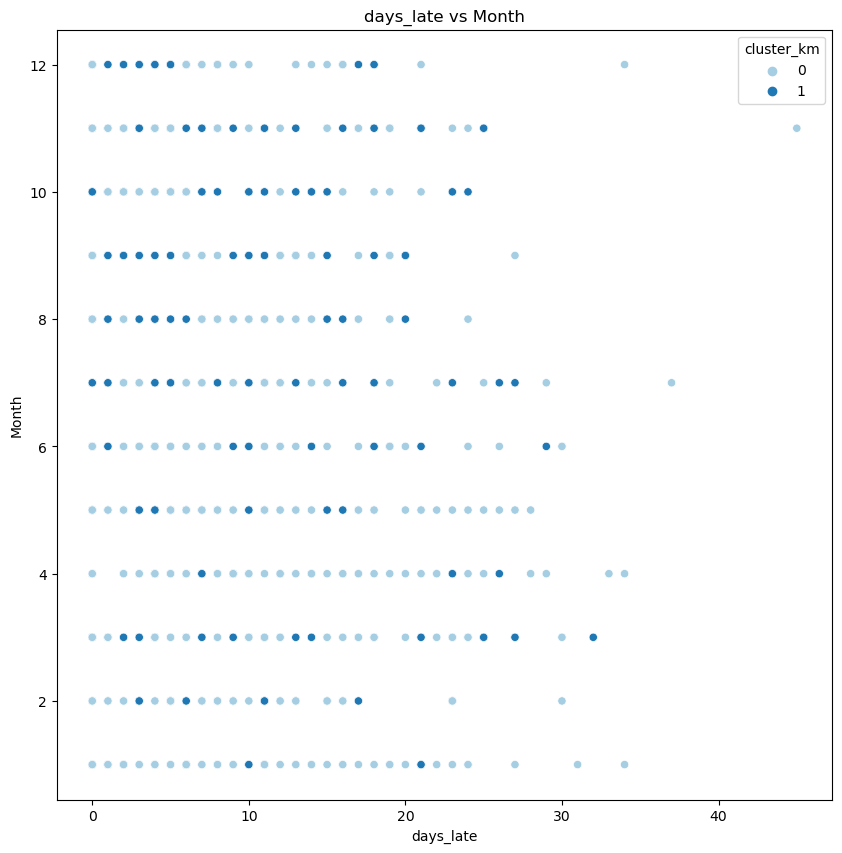

In [39]:
show_clusters_on_plot(ml_df, 'days_late', 'Month', 'cluster_km')

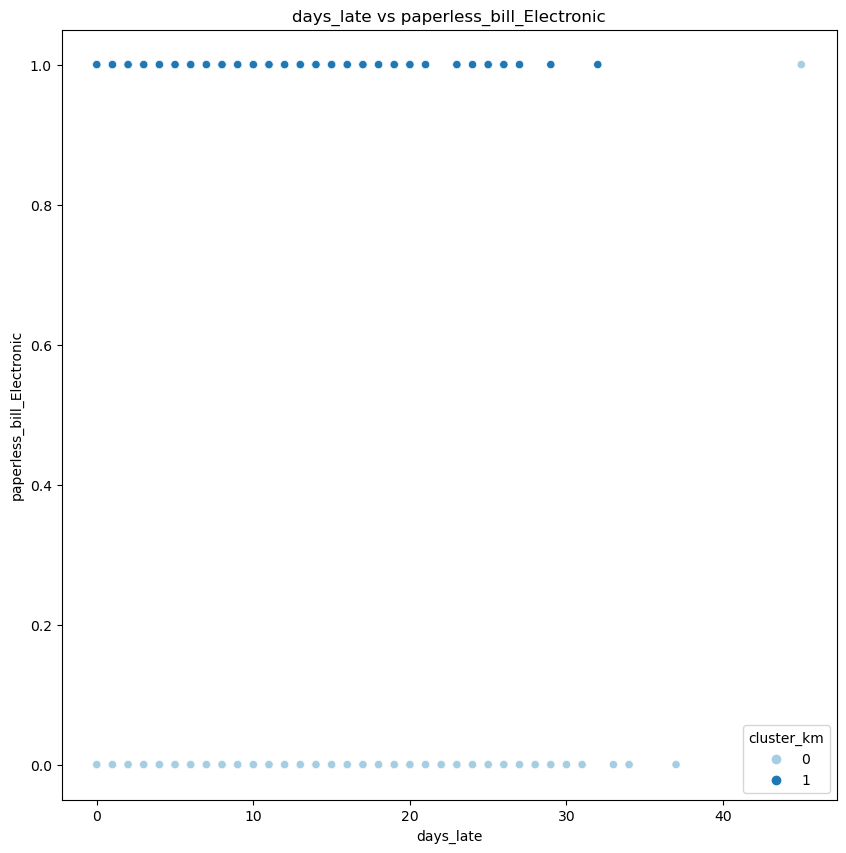

In [40]:
show_clusters_on_plot(ml_df, 'days_late', 'paperless_bill_Electronic', 'cluster_km')

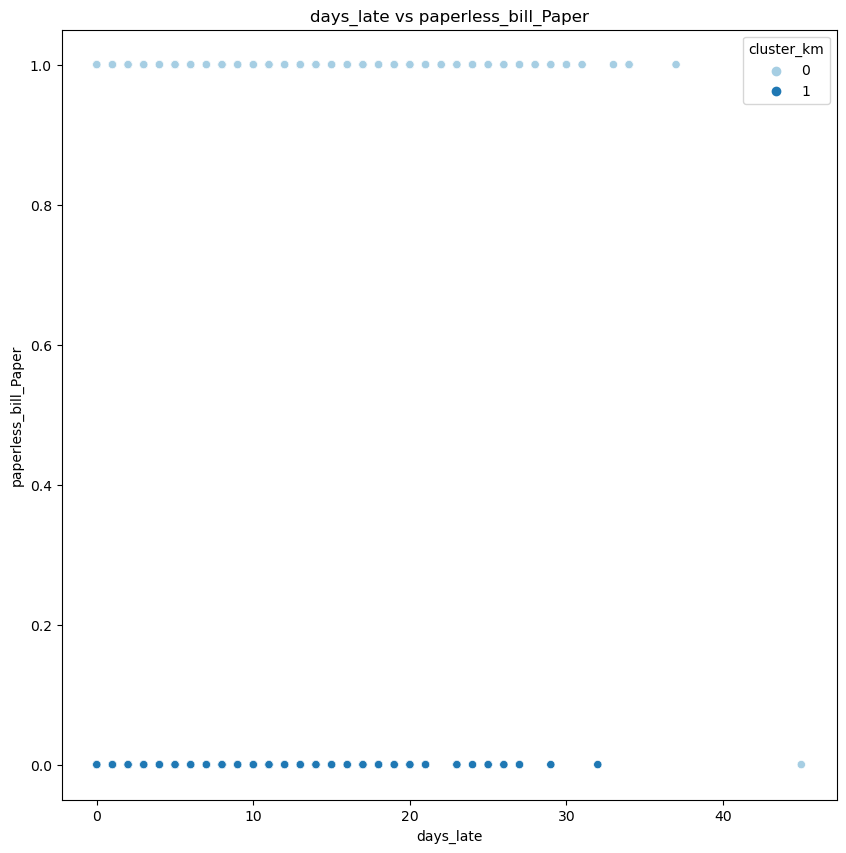

In [41]:
show_clusters_on_plot(ml_df, 'days_late', 'paperless_bill_Paper', 'cluster_km')

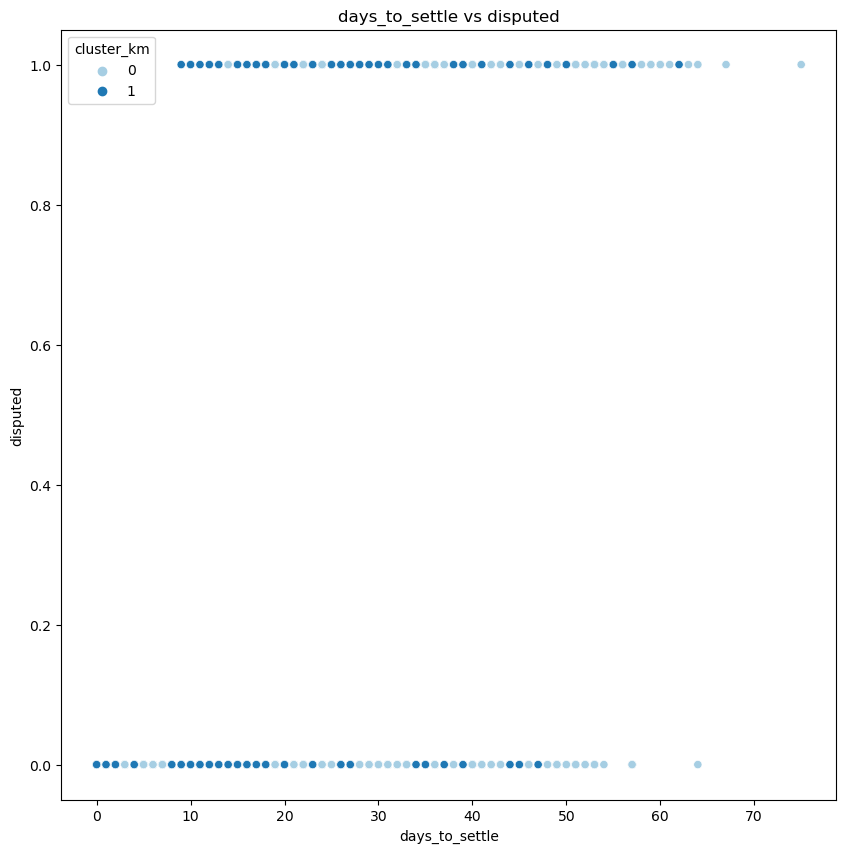

In [42]:
show_clusters_on_plot(ml_df, 'days_to_settle', 'disputed', 'cluster_km')

## Conclusiones 

A pesar de no haber un patrón específico podemos ver que los elementos que más influyen en la disputa de los clientes es el tiempo limite de pago, pues vemos que a partir de 30 dias se tiene una correlación estable entre ambos clusteres, sin embargo cuanto más días de límite de pago, mayor cantidad de atraso en las facturas. 
Así mismo observamos que si bien no hay una correlación directa entre las facturas atrasadas y los meses, los clientes con más días de atraso tienen facturas de los meses de julio, noviembre y diciembre. 
Así mismo vemos que las facturas en disputa se dan a partir de 10 días sin embargo esto se debería principalmente a que son facturas pagadas de contado.

Para este caso se recomienda revisar las politicas de pagos de clientes y establecer nuevos parámetros donde no haya tanta flexibilidad en las fechas limite de pago ya que como pudimos ver esto genera más atraso en los pagos y por ende mayor probababilidad de tener facturas en disputa